# Setup

In [17]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from experiments.irl.datasets import *
from experiments.irl.experiment_utils import *
from research.irl.fair_irl import *
from research.utils import *


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run experiments

In [261]:
base_exp_info = {
    'EXPERIMENT_NAME': 'conf_matrix_feat_exp_126',
    
    'FEAT_EXP_OBJECTIVE_NAMES': [
#         'Acc',
#         'DemPar',
#         'EqOpp',
        'TPR_Z0',
        'TPR_Z1',
        'TNR_Z0',
        'TNR_Z1',
        'FPR_Z0',
        'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
    ],
    'PERF_MEAS_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
    ],
    
    # Expert demo parameters
    'DATASET': 'COMPAS',
    'TARGET_DATASET': 'Adult',
    'N_EXPERT_DEMOS': 5,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 20_000,
    'MIN_FREQ_FILL_PCT': .02,
    'RESTRICT_Y_ACTION': True,
    # IRL Loop parameters
    'N_TRIALS': 10,
    'IRL_METHOD': None,
    'EPSILON': .01,
    'IGNORE_RESULTS_EPSILON': .02,
    'MAX_ITER': 20,
    'METHOD': 'highs',
    'IRL_ERROR_ENCOURAGE_SMALL_WEIGHTS': False,
    'IRL_ERROR_ENCOURAGE_LARGE_WEIGHTS': False,
    'ALLOW_NEG_WEIGHTS': True,
    # Plotting parameters
    'NOISE_FACTOR': .02,
    'ANNOTATE': True,
    'N_INIT_POLICIES': 3,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
        'HardtDemParNoisy',
#         'HardtEqOppNoisy',
#             'Dummy',
        'DummyNoisy',
    ],
}

In [262]:
experiments = [
    {
        'EXPERT_ALGO': 'OptAcc',
        'IRL_METHOD': 'FairIRL',
    },
    {
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRL',
    },
    {
        'EXPERT_ALGO': 'HardtEqOpp',
        'IRL_METHOD': 'FairIRL',
    },
]

In [263]:
# for exp_i, experiment in enumerate(experiments):
#     logging.info('\n\n')
#     logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
#     exp_info = dict(base_exp_info)
    
#     for k in experiment:
#         exp_info[k] = experiment[k]
        
#     run_experiment(exp_info)

In [264]:
exp_info = dict(base_exp_info)

source_X, source_y, source_feature_types = generate_dataset(
    exp_info['DATASET'],
    n_samples=exp_info['N_DATASET_SAMPLES'],
)
    
target_X, target_y, target_feature_types = generate_dataset(
    exp_info['TARGET_DATASET'],
    n_samples=exp_info['N_DATASET_SAMPLES'],
)

for f in source_feature_types['categoric']:
    source_X[f] = source_X[f].astype(str)
    
for f in target_feature_types['categoric']:
    target_X[f] = target_X[f].astype(str)

for exp_i, experiment in enumerate(experiments):
    logging.info('\n\n')
    logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
    exp_info = dict(base_exp_info)
    
    for k in experiment:
        exp_info[k] = experiment[k]
        
    run_experiment(
        exp_info,
        source_X=source_X,
        source_y=source_y,
        source_feature_types=source_feature_types,
        target_X=target_X,
        target_y=target_y,
        target_feature_types=target_feature_types,
    )

INFO:root:


INFO:root:EXPERIMENT 1/3
INFO:root:exp_info: {'EXPERIMENT_NAME': 'conf_matrix_feat_exp_126', 'FEAT_EXP_OBJECTIVE_NAMES': ['TPR_Z0', 'TPR_Z1', 'TNR_Z0', 'TNR_Z1', 'FPR_Z0', 'FPR_Z1'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'COMPAS', 'TARGET_DATASET': 'Adult', 'N_EXPERT_DEMOS': 5, 'EXPERT_ALGO': 'OptAcc', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.02, 'RESTRICT_Y_ACTION': True, 'N_TRIALS': 10, 'IRL_METHOD': 'FairIRL', 'EPSILON': 0.01, 'IGNORE_RESULTS_EPSILON': 0.02, 'MAX_ITER': 20, 'METHOD': 'highs', 'IRL_ERROR_ENCOURAGE_SMALL_WEIGHTS': False, 'IRL_ERROR_ENCOURAGE_LARGE_WEIGHTS': False, 'ALLOW_NEG_WEIGHTS': True, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True, 'N_INIT_POLICIES': 3, 'NON_EXPERT_ALGOS': ['OptAccNoisy', 'HardtDemParNoisy', 'DummyNoisy']}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.71189979 0.51707317 0.49555556 0.73308271 0.50444444 0.26691729]
 [0.76666667 0.51658768 0.47698745 0.67049808 0.52301255 0.32950192]
 [0.69462366 0.51428571 

INFO:root:		 Best mu_delta_hold[i] 	= [-0.075 -0.05   0.073  0.013 -0.073 -0.013]
INFO:root:		 t[15] 		= 0.03871
INFO:root:		 t_hold[i] 	= 0.02821
INFO:root:		 weights[15] 	= [ 0.126  0.566  0.025  0.129 -0.025 -0.129]
INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[16] = [0.741 0.426 0.515 0.797 0.485 0.203]
INFO:root:		 Best mu_delta[16] 	= [-0.012  0.068 -0.01  -0.064  0.01   0.064]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.075 -0.05   0.073  0.013 -0.073 -0.013]
INFO:root:		 t[16] 		= 0.03993
INFO:root:		 t_hold[i] 	= 0.02910
INFO:root:		 weights[16] 	= [ 0.117  0.584  0.021  0.128 -0.021 -0.128]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.721 0.434 0.539 0.785 0.461 0.215]
INFO:root:		 Best mu_delta[17] 	= [-0.012  0.068 -0.01  -0.064  0.01   0.064]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.075 -0.05   0.073  0.013 -0.073 -0.013]
INFO:root:		 t[17] 		= 0.04069
INFO:root:		 t_hold[i] 	= 0.02965
INFO:root:		 w

INFO:root:		 Best mu_delta_hold[i] 	= [-0.012  0.014  0.006  0.008 -0.006 -0.008]
INFO:root:		 t[12] 		= 0.02008
INFO:root:		 t_hold[i] 	= 0.00426
INFO:root:		 weights[12] 	= [ 0.287  0.292  0.146  0.065 -0.146 -0.065]
INFO:root:	IRL Loop iteration 14/20 ...
INFO:root:		 muL[13] = [0.721 0.425 0.545 0.783 0.455 0.217]
INFO:root:		 Best mu_delta[13] 	= [-0.009  0.069  0.003 -0.052 -0.003  0.052]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.012  0.014  0.006  0.008 -0.006 -0.008]
INFO:root:		 t[13] 		= 0.02059
INFO:root:		 t_hold[i] 	= 0.00434
INFO:root:		 weights[13] 	= [ 0.276  0.3    0.139  0.073 -0.139 -0.073]
INFO:root:	IRL Loop iteration 15/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[14] = [0.721 0.426 0.545 0.783 0.455 0.217]
INFO:root:		 Best mu_delta[14] 	= [-0.009  0.068  0.003 -0.052 -0.003  0.052]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.012  0.014  0.006  0.008 -0.006 -0.008]
INFO:root:		 t[14] 		= 0.01894
INFO:root:		 t_hold[i] 	= 0.00401
INFO:root:		 w

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.691,0.495,0.529,0.755,0.471,0.245,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.690,0.458,0.578,0.725,0.422,0.275,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.744,0.503,0.515,0.764,0.485,0.236,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.749,0.489,0.530,0.703,0.470,0.297,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.684,0.525,0.587,0.710,0.413,0.290,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.715,0.408,0.530,0.791,0.470,0.209,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.637,0.639,0.531,0.512,0.469,0.488,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.467,0.535,0.490,0.486,0.510,0.514,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.721,0.402,0.545,0.794,0.455,0.206,0,0.721,0.704,0.704,0.402,0.438,0.438,0.545,0.531,0.531,0.794,0.805,0.805,0.455,0.469,0.469,0.206,0.195,0.195,0.628,0.711,0.734,0.0,3.0,0.187,0.288,0.169,0.093,-0.169,-0.093,0.026,0.009,0.0,0.0
9,0.720,0.425,0.545,0.785,0.455,0.215,0,0.720,0.703,0.703,0.425,0.454,0.454,0.545,0.531,0.531,0.785,0.791,0.791,0.455,0.469,0.469,0.215,0.209,0.209,0.627,0.727,0.751,0.0,4.0,0.179,0.297,0.172,0.090,-0.172,-0.090,0.020,0.006,0.0,0.0


INFO:root:muE_target:
[[0.2173913  0.44700461 0.94366197 0.86682809 0.05633803 0.13317191]
 [0.46666667 0.44036697 0.93902439 0.85330073 0.06097561 0.14669927]
 [0.19354839 0.47321429 0.85185185 0.84278351 0.14814815 0.15721649]
 [0.40740741 0.39698492 0.91666667 0.89104116 0.08333333 0.10895884]
 [0.15789474 0.44140625 0.92957746 0.84880637 0.07042254 0.15119363]]
INFO:root:target domain muL = [0.383 0.44  0.884 0.87  0.116 0.13 ]
INFO:root:target domain muE = [0.289 0.44  0.916 0.861 0.084 0.139]
INFO:root:target domain muL_hold = [0.324 0.453 0.916 0.868 0.084 0.132]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.71492205 0.46327684 0.54325956 0.76895307 0.45674044 0.23104693]
 [0.73951435 0.52195122 0.54105263 0.72659176 0.45894737 0.27340824]
 [0.68218623 0.49489796 0.57173448 0.75308642 0.42826552 0.24691358]
 [0.60655738 0.47524752 0.63863636 0.66171004 0.36136364 0.33828996]
 [0.70264766 0.38613861 0.58482143 0.79844961 0.41517857 0.20155039]]
INFO:root:muE_hold:
[[0.74347826 0.505050

INFO:root:		 Best mu_delta[16] 	= [-0.034  0.044  0.032 -0.044 -0.032  0.044]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.015 -0.003  0.003  0.003 -0.003]
INFO:root:		 t[16] 		= 0.01273
INFO:root:		 t_hold[i] 	= 0.00176
INFO:root:		 weights[16] 	= [ 0.131  0.115  0.361  0.015 -0.361 -0.015]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.    0.429 1.    0.784 0.    0.216]
INFO:root:		 Best mu_delta[17] 	= [-0.034  0.044  0.032 -0.044 -0.032  0.044]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.015 -0.003  0.003  0.003 -0.003]
INFO:root:		 t[17] 		= 0.01485
INFO:root:		 t_hold[i] 	= 0.00518
INFO:root:		 weights[17] 	= [-0.04   0.34   0.221  0.089 -0.221 -0.089]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[18] = [0.739 0.425 0.516 0.788 0.484 0.212]
INFO:root:		 Best mu_delta[18] 	= [-0.034  0.044  0.032 -0.044 -0.032  0.044]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.001 -0.015 -0.003  0.003  0.003 -0.003]
I

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.715,0.463,0.543,0.769,0.457,0.231,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.740,0.522,0.541,0.727,0.459,0.273,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.682,0.495,0.572,0.753,0.428,0.247,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.607,0.475,0.639,0.662,0.361,0.338,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.703,0.386,0.585,0.798,0.415,0.202,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.684,0.412,0.525,0.848,0.475,0.152,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.656,0.674,0.504,0.484,0.496,0.516,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.460,0.389,0.532,0.523,0.468,0.477,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.749,0.575,0.506,0.214,0.494,0.786,0,0.749,0.752,0.752,0.575,0.547,0.547,0.506,0.498,0.498,0.214,0.216,0.216,0.494,0.502,0.502,0.786,0.784,0.784,0.541,0.951,0.794,0.0,3.0,0.396,-0.031,0.246,-0.041,-0.246,0.041,0.026,0.025,0.0,0.0
9,0.749,0.425,0.506,0.786,0.494,0.214,0,0.749,0.752,0.752,0.425,0.453,0.453,0.506,0.497,0.497,0.786,0.787,0.787,0.494,0.503,0.503,0.214,0.213,0.213,0.632,0.689,0.701,0.0,4.0,0.315,0.151,0.238,0.028,-0.238,-0.028,0.020,0.005,0.0,0.0


INFO:root:muE_target:
[[0.19230769 0.37614679 0.95604396 0.8714653  0.04395604 0.1285347 ]
 [0.41176471 0.5045045  0.85185185 0.84405941 0.14814815 0.15594059]
 [0.24       0.47887324 0.94666667 0.83454988 0.05333333 0.16545012]
 [0.38095238 0.46606335 0.98529412 0.83292978 0.01470588 0.16707022]
 [0.5        0.39090909 0.89285714 0.87969925 0.10714286 0.12030075]]
INFO:root:target domain muL = [0.239 0.476 0.952 0.859 0.048 0.141]
INFO:root:target domain muE = [0.345 0.443 0.927 0.853 0.073 0.147]
INFO:root:target domain muL_hold = [0.173 0.455 0.947 0.856 0.053 0.144]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.71956522 0.40930233 0.57236842 0.76208178 0.42763158 0.23791822]
 [0.69979296 0.48514851 0.52711497 0.69291339 0.47288503 0.30708661]
 [0.68924303 0.43005181 0.56681034 0.84232365 0.43318966 0.15767635]
 [0.714      0.42564103 0.54923414 0.7854251  0.45076586 0.2145749 ]
 [0.67538126 0.32160804 0.57939914 0.82545455 0.42060086 0.17454545]]
INFO:root:muE_hold:
[[0.72532189 0.390476

INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:		 muL[16] = [0.748 0.    0.493 1.    0.507 0.   ]
INFO:root:		 Best mu_delta[16] 	= [-0.032 -0.16   0.038  0.574 -0.038 -0.574]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.027 -0.218  0.034  0.581 -0.034 -0.581]
INFO:root:		 t[16] 		= 0.01334
INFO:root:		 t_hold[i] 	= 0.01177
INFO:root:		 weights[16] 	= [ 0.39  -0.015  0.291  0.007 -0.291 -0.007]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.741 0.    0.497 1.    0.503 0.   ]
INFO:root:		 Best mu_delta[17] 	= [-0.032 -0.16   0.038  0.574 -0.038 -0.574]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.027 -0.218  0.034  0.581 -0.034 -0.581]
INFO:root:		 t[17] 		= 0.01390
INFO:root:		 t_hold[i] 	= 0.01250
INFO:root:		 weights[17] 	= [ 0.323 -0.01   0.33   0.003 -0.33  -0.003]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:		 muL[18] = [0.741 0.567 0.497 0.212 0.503 0.788]
INFO:root:		 Best mu_delta[18] 	= [-0.032 -0.16   0.038  0.574 -0.038 -0.574]
INFO:root:		 Best mu_delt

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.720,0.409,0.572,0.762,0.428,0.238,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.700,0.485,0.527,0.693,0.473,0.307,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.689,0.430,0.567,0.842,0.433,0.158,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.714,0.426,0.549,0.785,0.451,0.215,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.675,0.322,0.579,0.825,0.421,0.175,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.758,0.391,0.480,0.880,0.520,0.120,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.665,0.630,0.512,0.483,0.488,0.517,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.468,0.487,0.487,0.469,0.513,0.531,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.000,0.000,1.000,1.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.521,1.000,1.000,0.0,3.0,-0.027,-0.112,0.426,0.004,-0.426,-0.004,0.205,0.199,0.0,0.0
9,0.744,0.567,0.497,0.212,0.503,0.788,0,0.744,0.762,0.762,0.567,0.563,0.563,0.497,0.520,0.520,0.212,0.215,0.215,0.503,0.480,0.480,0.788,0.785,0.785,0.548,0.932,0.801,0.0,4.0,0.350,-0.086,0.234,-0.048,-0.234,0.048,0.030,0.030,0.0,0.0


INFO:root:muE_target:
[[0.31818182 0.41409692 0.94594595 0.87032419 0.05405405 0.12967581]
 [0.27272727 0.43627451 0.82278481 0.90214797 0.17721519 0.09785203]
 [0.33333333 0.4137931  0.93181818 0.8775     0.06818182 0.1225    ]
 [0.34782609 0.41463415 0.82278481 0.89423077 0.17721519 0.10576923]
 [0.08333333 0.47983871 0.92424242 0.8961039  0.07575758 0.1038961 ]]
INFO:root:target domain muL = [0.323 0.561 0.899 0.131 0.101 0.869]
INFO:root:target domain muE = [0.271 0.432 0.89  0.888 0.11  0.112]
INFO:root:target domain muL_hold = [0.311 0.573 0.913 0.136 0.087 0.864]
INFO:root:

TRIAL 4

INFO:root:muE:
[[0.70186335 0.43255814 0.51801802 0.80620155 0.48198198 0.19379845]
 [0.74633124 0.39086294 0.50547046 0.78438662 0.49452954 0.21561338]
 [0.73739496 0.40740741 0.51859956 0.82014388 0.48140044 0.17985612]
 [0.67908903 0.38659794 0.58114035 0.84210526 0.41885965 0.15789474]
 [0.66877637 0.49746193 0.54945055 0.76556777 0.45054945 0.23443223]]
INFO:root:muE_hold:
[[0.804      0.505376

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.702,0.433,0.518,0.806,0.482,0.194,1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.746,0.391,0.505,0.784,0.495,0.216,1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.737,0.407,0.519,0.820,0.481,0.180,1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.679,0.387,0.581,0.842,0.419,0.158,1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.669,0.497,0.549,0.766,0.451,0.234,1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.00,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.699,0.564,0.553,0.695,0.447,0.305,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.00,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.681,0.628,0.538,0.478,0.462,0.522,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.00,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.497,0.426,0.477,0.478,0.523,0.522,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.00,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.300,0.000,0.447,1.000,0.553,0.000,0,0.3,0.290,0.290,0.000,0.000,0.000,0.447,0.464,0.464,1.000,1.0,1.0,0.553,0.536,0.536,0.000,0.0,0.0,0.435,0.590,0.71,0.0,3.0,-0.122,-0.272,-0.013,0.290,0.013,-0.290,0.115,0.128,0.0,0.0
9,0.700,0.466,0.553,0.789,0.447,0.211,0,0.7,0.708,0.708,0.466,0.448,0.448,0.553,0.537,0.537,0.789,0.8,0.8,0.447,0.463,0.463,0.211,0.2,0.2,0.631,0.722,0.74,0.0,4.0,0.211,0.088,0.097,0.253,-0.097,-0.253,0.004,0.014,0.0,0.0


INFO:root:muE_target:
[[0.34375    0.5042735  0.8974359  0.89210526 0.1025641  0.10789474]
 [0.22222222 0.51327434 0.92405063 0.85714286 0.07594937 0.14285714]
 [0.33333333 0.51363636 0.90410959 0.87376238 0.09589041 0.12623762]
 [0.41666667 0.46153846 0.87777778 0.82850242 0.12222222 0.17149758]
 [0.29166667 0.47659574 0.9375     0.87760417 0.0625     0.12239583]]
INFO:root:target domain muL = [0.366 0.479 0.902 0.871 0.098 0.129]
INFO:root:target domain muE = [0.322 0.494 0.908 0.866 0.092 0.134]
INFO:root:target domain muL_hold = [0.303 0.446 0.931 0.844 0.069 0.156]
INFO:root:

TRIAL 5

INFO:root:muE:
[[0.73150106 0.42051282 0.54030501 0.76190476 0.45969499 0.23809524]
 [0.72908367 0.44390244 0.52       0.77985075 0.48       0.22014925]
 [0.69375    0.43684211 0.56550218 0.82352941 0.43449782 0.17647059]
 [0.71861472 0.44444444 0.47727273 0.79120879 0.52272727 0.20879121]
 [0.66373626 0.38071066 0.50102669 0.77692308 0.49897331 0.22307692]]
INFO:root:muE_hold:
[[0.72052402 0.53    

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.732,0.421,0.540,0.762,0.460,0.238,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.729,0.444,0.520,0.780,0.480,0.220,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.694,0.437,0.566,0.824,0.434,0.176,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.719,0.444,0.477,0.791,0.523,0.209,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.664,0.381,0.501,0.777,0.499,0.223,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.764,0.452,0.513,0.791,0.487,0.209,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.654,0.623,0.494,0.499,0.506,0.501,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.504,0.562,0.510,0.493,0.490,0.507,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.000,0.000,1.000,1.000,0.000,0.000,0,0.000,0.000,0.000,0.00,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.504,1.000,1.000,0.0,3.0,-0.368,-0.244,0.079,0.115,-0.079,-0.115,0.260,0.260,0.0,0.0
9,1.000,0.570,0.000,0.202,1.000,0.798,0,1.000,0.998,0.998,0.57,0.561,0.561,0.000,0.001,0.001,0.202,0.203,0.203,1.000,0.999,0.999,0.798,0.797,0.797,0.469,0.693,0.563,0.0,4.0,0.183,-0.474,-0.007,-0.165,0.007,0.165,0.106,0.097,0.0,0.0


INFO:root:muE_target:
[[0.18181818 0.56164384 0.92857143 0.88619855 0.07142857 0.11380145]
 [0.23529412 0.5        0.93333333 0.8875     0.06666667 0.1125    ]
 [0.25       0.46078431 0.94520548 0.88888889 0.05479452 0.11111111]
 [0.10526316 0.47706422 0.92708333 0.85384615 0.07291667 0.14615385]
 [0.35714286 0.45454545 0.83544304 0.87373737 0.16455696 0.12626263]]
INFO:root:target domain muL = [0.391 0.418 0.896 0.9   0.104 0.1  ]
INFO:root:target domain muE = [0.226 0.491 0.914 0.878 0.086 0.122]
INFO:root:target domain muL_hold = [0.274 0.398 0.908 0.876 0.092 0.124]
INFO:root:

TRIAL 6

INFO:root:muE:
[[0.72553191 0.34761905 0.4845815  0.80827068 0.5154185  0.19172932]
 [0.75630252 0.36507937 0.51167728 0.85227273 0.48832272 0.14772727]
 [0.66396761 0.41145833 0.5237069  0.804      0.4762931  0.196     ]
 [0.71338912 0.40776699 0.59192825 0.80669145 0.40807175 0.19330855]
 [0.75840336 0.41758242 0.48101266 0.78651685 0.51898734 0.21348315]]
INFO:root:muE_hold:
[[0.6953125  0.347826

INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:		 muL[16] = [0.696 0.522 0.551 0.72  0.449 0.28 ]
INFO:root:		 Best mu_delta[16] 	= [ 0.032 -0.063 -0.037  0.031  0.037 -0.031]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.021 -0.029 -0.034  0.01   0.034 -0.01 ]
INFO:root:		 t[16] 		= 0.02346
INFO:root:		 t_hold[i] 	= 0.01069
INFO:root:		 weights[16] 	= [ 0.009  0.375  0.008  0.3   -0.008 -0.3  ]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.696 0.454 0.55  0.78  0.45  0.22 ]
INFO:root:		 Best mu_delta[17] 	= [ 0.032 -0.063 -0.037  0.031  0.037 -0.031]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.021 -0.029 -0.034  0.01   0.034 -0.01 ]
INFO:root:		 t[17] 		= 0.01893
INFO:root:		 t_hold[i] 	= 0.00862
INFO:root:		 weights[17] 	= [ 0.044  0.302  0.025  0.302 -0.025 -0.302]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[18] = [0.696 0.523 0.55  0.72  0.45  0.28 ]
INFO:root:		 Best mu_delta[18] 	= [ 0.032 -0.063 -0.037  0.0

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.726,0.348,0.485,0.808,0.515,0.192,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.756,0.365,0.512,0.852,0.488,0.148,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.664,0.411,0.524,0.804,0.476,0.196,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.713,0.408,0.592,0.807,0.408,0.193,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.758,0.418,0.481,0.787,0.519,0.213,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.549,0.380,0.637,0.828,0.363,0.172,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.638,0.610,0.533,0.520,0.467,0.480,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.489,0.466,0.518,0.505,0.482,0.495,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,1.000,0.000,0.000,1.000,1.000,0.000,0,1.000,0.999,0.999,0.000,0.000,0.000,0.000,0.001,0.001,1.00,1.000,1.000,1.000,0.999,0.999,0.00,0.000,0.000,0.524,0.001,0.001,0.0,3.0,0.433,-0.036,-0.162,0.103,0.162,-0.103,0.121,0.133,0.0,0.0
9,0.692,0.453,0.556,0.780,0.444,0.220,0,0.692,0.674,0.674,0.453,0.452,0.452,0.556,0.592,0.592,0.78,0.790,0.790,0.444,0.408,0.408,0.22,0.210,0.210,0.636,0.773,0.778,0.0,4.0,0.349,0.255,0.079,0.119,-0.079,-0.119,0.016,0.008,0.0,0.0


INFO:root:muE_target:
[[0.25806452 0.46188341 0.92307692 0.88520408 0.07692308 0.11479592]
 [0.2        0.4084507  0.92105263 0.88674699 0.07894737 0.11325301]
 [0.375      0.43661972 0.90625    0.84398977 0.09375    0.15601023]
 [0.25925926 0.46460177 0.94202899 0.87032419 0.05797101 0.12967581]
 [0.25       0.48989899 0.95180723 0.87203791 0.04819277 0.12796209]]
INFO:root:target domain muL = [0.352 0.449 0.915 0.884 0.085 0.116]
INFO:root:target domain muE = [0.268 0.452 0.929 0.872 0.071 0.128]
INFO:root:target domain muL_hold = [0.32  0.423 0.92  0.883 0.08  0.117]
INFO:root:

TRIAL 7

INFO:root:muE:
[[0.69491525 0.375      0.51077586 0.79285714 0.48922414 0.20714286]
 [0.72283814 0.50248756 0.51464435 0.77407407 0.48535565 0.22592593]
 [0.68333333 0.30808081 0.55981941 0.87455197 0.44018059 0.12544803]
 [0.68789809 0.47979798 0.51612903 0.7991453  0.48387097 0.2008547 ]
 [0.72406639 0.34653465 0.49350649 0.85375494 0.50649351 0.14624506]]
INFO:root:muE_hold:
[[0.65       0.517857

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.695,0.375,0.511,0.793,0.489,0.207,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.723,0.502,0.515,0.774,0.485,0.226,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.683,0.308,0.560,0.875,0.440,0.125,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.688,0.480,0.516,0.799,0.484,0.201,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.724,0.347,0.494,0.854,0.506,0.146,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.705,0.402,0.581,0.794,0.419,0.206,0,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.636,0.575,0.591,0.527,0.409,0.473,0,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.510,0.480,0.517,0.462,0.483,0.538,0,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.286,0.443,0.469,0.807,0.531,0.193,0,0.286,0.29,0.29,0.443,0.449,0.449,0.469,0.484,0.484,0.807,0.791,0.791,0.531,0.516,0.516,0.193,0.209,0.209,0.469,0.915,0.842,0.0,3.0,-0.008,0.050,-0.293,0.178,0.293,-0.178,0.016,0.021,0.0,0.0
9,1.000,0.402,0.000,0.824,1.000,0.176,0,0.286,1.00,0.29,0.443,0.422,0.449,0.469,0.001,0.484,0.807,0.823,0.791,0.531,0.999,0.516,0.193,0.177,0.209,0.469,0.915,0.842,0.0,4.0,0.143,0.033,-0.243,0.169,0.243,-0.169,0.060,0.055,0.0,0.0


INFO:root:muE_target:
[[0.55555556 0.47393365 0.90789474 0.81622912 0.09210526 0.18377088]
 [0.33333333 0.47058824 0.96341463 0.83211679 0.03658537 0.16788321]
 [0.21052632 0.42372881 0.92857143 0.87218045 0.07142857 0.12781955]
 [0.2962963  0.46443515 0.91111111 0.86103542 0.08888889 0.13896458]
 [0.31578947 0.46759259 0.88095238 0.86633663 0.11904762 0.13366337]]
INFO:root:target domain muL = [0.273 0.441 0.923 0.876 0.077 0.124]
INFO:root:target domain muE = [0.342 0.46  0.918 0.85  0.082 0.15 ]
INFO:root:target domain muL_hold = [0.206 0.425 0.925 0.877 0.075 0.123]
INFO:root:

TRIAL 8

INFO:root:muE:
[[0.64634146 0.39393939 0.60434783 0.816      0.39565217 0.184     ]
 [0.68468468 0.36585366 0.55314534 0.81034483 0.44685466 0.18965517]
 [0.66173362 0.39408867 0.62863535 0.77617329 0.37136465 0.22382671]
 [0.68865979 0.44508671 0.57261411 0.75675676 0.42738589 0.24324324]
 [0.68115942 0.37055838 0.5678733  0.84115523 0.4321267  0.15884477]]
INFO:root:muE_hold:
[[0.54581673 0.540816

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.646,0.394,0.604,0.816,0.396,0.184,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.685,0.366,0.553,0.810,0.447,0.190,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.662,0.394,0.629,0.776,0.371,0.224,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.689,0.445,0.573,0.757,0.427,0.243,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.681,0.371,0.568,0.841,0.432,0.159,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.691,0.384,0.574,0.833,0.426,0.167,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.647,0.607,0.576,0.484,0.424,0.516,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.477,0.523,0.507,0.507,0.493,0.493,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.695,0.617,0.549,0.182,0.451,0.818,0,0.695,0.717,0.717,0.617,0.559,0.559,0.549,0.538,0.538,0.182,0.178,0.178,0.451,0.462,0.462,0.818,0.822,0.822,0.535,0.885,0.843,0.0,3.0,0.162,-0.465,0.032,-0.155,-0.032,0.155,0.113,0.096,0.0,0.0
9,0.000,0.582,1.000,0.203,0.000,0.797,0,0.695,0.000,0.717,0.617,0.516,0.559,0.549,1.000,0.538,0.182,0.196,0.178,0.451,0.000,0.462,0.818,0.804,0.822,0.535,0.885,0.843,0.0,4.0,-0.170,-0.186,0.279,-0.043,-0.279,0.043,0.042,0.026,0.0,0.0


INFO:root:muE_target:
[[0.24137931 0.45714286 0.89333333 0.85609756 0.10666667 0.14390244]
 [0.34375    0.37837838 0.83950617 0.88431877 0.16049383 0.11568123]
 [0.38888889 0.46982759 0.85074627 0.82309582 0.14925373 0.17690418]
 [0.16       0.44700461 0.88235294 0.84343434 0.11764706 0.15656566]
 [0.52       0.38604651 0.88888889 0.88321168 0.11111111 0.11678832]]
INFO:root:target domain muL = [0.186 0.44  0.95  0.841 0.05  0.159]
INFO:root:target domain muE = [0.331 0.428 0.871 0.858 0.129 0.142]
INFO:root:target domain muL_hold = [0.203 0.468 0.955 0.855 0.045 0.145]
INFO:root:

TRIAL 9

INFO:root:muE:
[[0.69747899 0.40686275 0.49788136 0.8266129  0.50211864 0.1733871 ]
 [0.70661157 0.40957447 0.51548673 0.76811594 0.48451327 0.23188406]
 [0.67695473 0.44848485 0.56813417 0.81617647 0.43186583 0.18382353]
 [0.62156448 0.46875    0.56703297 0.78136201 0.43296703 0.21863799]
 [0.68842105 0.34101382 0.59484778 0.85714286 0.40515222 0.14285714]]
INFO:root:muE_hold:
[[0.66795367 0.431818

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.697,0.407,0.498,0.827,0.502,0.173,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.707,0.410,0.515,0.768,0.485,0.232,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.677,0.448,0.568,0.816,0.432,0.184,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.622,0.469,0.567,0.781,0.433,0.219,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.688,0.341,0.595,0.857,0.405,0.143,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.717,0.521,0.544,0.738,0.456,0.262,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.683,0.657,0.528,0.481,0.472,0.519,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.493,0.502,0.492,0.496,0.508,0.504,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.297,0.000,0.470,1.000,0.530,0.000,0,0.297,0.291,0.291,0.000,0.000,0.000,0.470,0.473,0.473,1.000,1.000,1.000,0.530,0.527,0.527,0.000,0.000,0.000,0.443,0.592,0.709,0.0,3.0,-0.240,-0.390,-0.017,0.168,0.017,-0.168,0.162,0.147,0.0,0.0
9,0.704,0.000,0.530,1.000,0.470,0.000,0,0.704,0.708,0.708,0.000,0.000,0.000,0.530,0.526,0.526,1.000,1.000,1.000,0.470,0.474,0.474,0.000,0.000,0.000,0.601,0.408,0.292,0.0,4.0,0.209,-0.122,0.224,0.110,-0.224,-0.110,0.051,0.046,0.0,0.0


INFO:root:muE_target:
[[0.24       0.56744186 0.96202532 0.82962963 0.03797468 0.17037037]
 [0.47619048 0.38990826 0.86904762 0.88029925 0.13095238 0.11970075]
 [0.33333333 0.36086957 0.88235294 0.90225564 0.11764706 0.09774436]
 [0.33333333 0.44334975 0.90697674 0.85230024 0.09302326 0.14769976]
 [0.48275862 0.44642857 0.9375     0.86666667 0.0625     0.13333333]]
INFO:root:target domain muL = [0.707 0.428 0.063 0.873 0.937 0.127]
INFO:root:target domain muE = [0.373 0.442 0.912 0.866 0.088 0.134]
INFO:root:target domain muL_hold = [0.675 0.449 0.115 0.866 0.885 0.134]
INFO:root:


INFO:root:EXPERIMENT 2/3
INFO:root:exp_info: {'EXPERIMENT_NAME': 'conf_matrix_feat_exp_126', 'FEAT_EXP_OBJECTIVE_NAMES': ['TPR_Z0', 'TPR_Z1', 'TNR_Z0', 'TNR_Z1', 'FPR_Z0', 'FPR_Z1'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'COMPAS', 'TARGET_DATASET': 'Adult', 'N_EXPERT_DEMOS': 5, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.02, 'RESTRICT_Y_ACTI

INFO:root:	IRL Loop iteration 15/20 ...
INFO:root:		 muL[14] = [0.749 0.456 0.515 0.769 0.485 0.231]
INFO:root:		 Best mu_delta[14] 	= [-0.044  0.187  0.046 -0.303 -0.046  0.303]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.098  0.156  0.07  -0.253 -0.07   0.253]
INFO:root:		 t[14] 		= 0.01627
INFO:root:		 t_hold[i] 	= 0.03480
INFO:root:		 weights[14] 	= [ 0.353  0.065  0.259  0.032 -0.259 -0.032]
INFO:root:	IRL Loop iteration 16/20 ...
INFO:root:		 muL[15] = [0.251 0.458 0.485 0.767 0.515 0.233]
INFO:root:		 Best mu_delta[15] 	= [-0.047  0.103  0.046  0.232 -0.046 -0.232]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.098  0.156  0.07  -0.253 -0.07   0.253]
INFO:root:		 t[15] 		= 0.04012
INFO:root:		 t_hold[i] 	= 0.05237
INFO:root:		 weights[15] 	= [-0.218  0.328 -0.074  0.153  0.074 -0.153]
INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:		 muL[16] = [0.    0.543 1.    0.233 0.    0.767]
INFO:root:		 Best mu_delta[16] 	= [ 0.453  0.099  0.075  0.235 -0.075 -0.235]
INFO:root:		 Best mu_delt

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.741,0.624,0.552,0.472,0.448,0.528,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.694,0.665,0.568,0.530,0.432,0.470,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.721,0.611,0.570,0.389,0.430,0.611,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.688,0.708,0.517,0.452,0.483,0.548,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.664,0.618,0.597,0.474,0.403,0.526,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.726,0.413,0.533,0.792,0.467,0.208,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.703,0.594,0.513,0.529,0.487,0.471,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.489,0.528,0.493,0.496,0.507,0.504,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.749,1.000,0.515,0.000,0.485,1.000,0,0.749,0.760,0.760,1.000,0.992,0.992,0.515,0.496,0.496,0.000,0.003,0.003,0.485,0.504,0.504,1.000,0.997,0.997,0.566,0.636,0.767,0.0,3.0,0.062,0.247,0.223,-0.123,-0.223,0.123,0.088,0.091,0.0,0.0
9,0.000,0.456,1.000,0.770,0.000,0.230,0,0.749,0.000,0.760,1.000,0.474,0.992,0.515,1.000,0.496,0.000,0.804,0.003,0.485,0.000,0.504,1.000,0.196,0.997,0.566,0.636,0.767,0.0,4.0,-0.146,0.184,0.275,0.060,-0.275,-0.060,0.065,0.066,0.0,0.0


INFO:root:muE_target:
[[0.31818182 0.425      0.83950617 0.86460808 0.16049383 0.13539192]
 [0.29411765 0.36486486 0.80487805 0.87305699 0.19512195 0.12694301]
 [0.57894737 0.41588785 0.81944444 0.85441527 0.18055556 0.14558473]
 [0.32       0.4109589  0.8045977  0.86989796 0.1954023  0.13010204]
 [0.23076923 0.38095238 0.86842105 0.88077859 0.13157895 0.11922141]]
INFO:root:target domain muL = [0.151 0.419 0.937 0.862 0.063 0.138]
INFO:root:target domain muE = [0.348 0.4   0.827 0.869 0.173 0.131]
INFO:root:target domain muL_hold = [0.197 0.436 0.959 0.876 0.041 0.124]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.75770925 0.73831776 0.49892009 0.42750929 0.50107991 0.57249071]
 [0.76043956 0.70935961 0.52597403 0.425      0.47402597 0.575     ]
 [0.68162393 0.6875     0.56659619 0.46215139 0.43340381 0.53784861]
 [0.70242915 0.66666667 0.55684455 0.53183521 0.44315545 0.46816479]
 [0.69367589 0.58888889 0.59267735 0.48188406 0.40732265 0.51811594]]
INFO:root:muE_hold:
[[0.67400881 0.621621

INFO:root:		 t[15] 		= 0.05827
INFO:root:		 t_hold[i] 	= 0.04907
INFO:root:		 weights[15] 	= [ 0.214  0.231  0.229  0.048 -0.229 -0.048]
INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:		 muL[16] = [0.735 0.425 0.516 0.809 0.484 0.191]
INFO:root:		 Best mu_delta[16] 	= [-0.006  0.252  0.024 -0.342 -0.024  0.342]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.055  0.212  0.085 -0.297 -0.085  0.297]
INFO:root:		 t[16] 		= 0.05827
INFO:root:		 t_hold[i] 	= 0.04907
INFO:root:		 weights[16] 	= [ 0.214  0.231  0.229  0.048 -0.229 -0.048]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.735 0.425 0.516 0.81  0.484 0.19 ]
INFO:root:		 Best mu_delta[17] 	= [-0.006  0.252  0.024 -0.342 -0.024  0.342]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.055  0.212  0.085 -0.297 -0.085  0.297]
INFO:root:		 t[17] 		= 0.05827
INFO:root:		 t_hold[i] 	= 0.04907
INFO:root:		 weights[17] 	= [ 0.214  0.231  0.229  0.048 -0.229 -0.048]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:		 muL[18] = [0.7

INFO:root:		 t[12] 		= 0.01666
INFO:root:		 t_hold[i] 	= 0.02415
INFO:root:		 weights[12] 	= [ 0.378  0.     0.311 -0.    -0.311  0.   ]
INFO:root:	IRL Loop iteration 14/20 ...
INFO:root:		 muL[13] = [0.749 0.507 0.523 0.279 0.477 0.721]
INFO:root:		 Best mu_delta[13] 	= [-0.044  0.146  0.032  0.194 -0.032 -0.194]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.064  0.12   0.046  0.187 -0.046 -0.187]
INFO:root:		 t[13] 		= 0.01752
INFO:root:		 t_hold[i] 	= 0.02540
INFO:root:		 weights[13] 	= [ 0.399 -0.015  0.285 -0.008 -0.285  0.008]
INFO:root:	IRL Loop iteration 15/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[14] = [0.752 0.519 0.518 0.271 0.482 0.729]
INFO:root:		 Best mu_delta[14] 	= [-0.044  0.146  0.032  0.194 -0.032 -0.194]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.064  0.134  0.046 -0.264 -0.046  0.264]
INFO:root:		 t[14] 		= 0.01709
INFO:root:		 t_hold[i] 	= 0.02477
INFO:root:		 weights[14] 	= [ 0.388 -0.002  0.304 -0.    -0.304  0.   ]
INFO:root:	IRL Loop iter

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.675,0.635,0.563,0.423,0.437,0.577,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.704,0.667,0.559,0.512,0.441,0.488,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.676,0.577,0.583,0.492,0.417,0.508,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.755,0.715,0.512,0.462,0.488,0.538,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.718,0.650,0.560,0.486,0.440,0.514,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.757,0.539,0.446,0.740,0.554,0.260,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.659,0.588,0.534,0.556,0.466,0.444,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.521,0.540,0.477,0.471,0.523,0.529,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.752,1.000,0.518,0.000,0.482,1.000,0,0.752,0.735,0.735,1.000,0.998,0.998,0.518,0.506,0.506,0.000,0.003,0.003,0.482,0.494,0.494,1.000,0.997,0.997,0.556,0.618,0.737,0.0,3.0,0.125,0.142,0.148,-0.219,-0.148,0.219,0.113,0.109,0.0,0.0
9,0.758,0.506,0.517,0.277,0.483,0.723,0,0.758,0.739,0.739,0.506,0.495,0.495,0.517,0.499,0.499,0.277,0.278,0.278,0.483,0.501,0.501,0.723,0.722,0.722,0.537,0.995,0.756,0.0,4.0,0.411,-0.100,0.234,-0.010,-0.234,0.010,0.022,0.028,0.0,0.0


INFO:root:muE_target:
[[0.375      0.43243243 0.87777778 0.87886598 0.12222222 0.12113402]
 [0.53571429 0.39215686 0.73493976 0.85085575 0.26506024 0.14914425]
 [0.52631579 0.47033898 0.8028169  0.83919598 0.1971831  0.16080402]
 [0.52173913 0.43203883 0.81944444 0.88151659 0.18055556 0.11848341]
 [0.65217391 0.44255319 0.76271186 0.86453202 0.23728814 0.13546798]]
INFO:root:target domain muL = [0.231 0.558 0.941 0.145 0.059 0.855]
INFO:root:target domain muE = [0.522 0.434 0.8   0.863 0.2   0.137]
INFO:root:target domain muL_hold = [0.195 0.545 0.952 0.153 0.048 0.847]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.708061   0.65581395 0.52783964 0.59205776 0.47216036 0.40794224]
 [0.71774194 0.69607843 0.52953586 0.44690265 0.47046414 0.55309735]
 [0.73076923 0.71782178 0.54945055 0.44176707 0.45054945 0.55823293]
 [0.6877551  0.61340206 0.54788419 0.51879699 0.45211581 0.48120301]
 [0.76826722 0.67724868 0.48619958 0.4        0.51380042 0.6       ]]
INFO:root:muE_hold:
[[0.68122271 0.623762

INFO:root:		 muL[16] = [0.652 0.466 0.584 0.792 0.416 0.208]
INFO:root:		 Best mu_delta[16] 	= [ 0.07   0.672 -0.054 -0.52   0.054  0.52 ]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.062  0.112 -0.034  0.306  0.034 -0.306]
INFO:root:		 t[16] 		= 0.04351
INFO:root:		 t_hold[i] 	= 0.03847
INFO:root:		 weights[16] 	= [ 0.619  0.     0.183  0.007 -0.183 -0.007]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.649 0.455 0.587 0.801 0.413 0.199]
INFO:root:		 Best mu_delta[17] 	= [ 0.07   0.672 -0.054 -0.52   0.054  0.52 ]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.062  0.112 -0.034  0.306  0.034 -0.306]
INFO:root:		 t[17] 		= 0.04363
INFO:root:		 t_hold[i] 	= 0.03857
INFO:root:		 weights[17] 	= [ 0.62   0.001  0.187  0.002 -0.187 -0.002]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:		 muL[18] = [0.653 0.447 0.581 0.808 0.419 0.192]
INFO:root:		 Best mu_delta[18] 	= [ 0.07   0.225 -0.053 -0.328  0.053  0.328]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.062  0.194 -0.032 -0.30

INFO:root:		 Best mu_delta[13] 	= [-0.03   0.197  0.04  -0.267 -0.04   0.267]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.032  0.217  0.036 -0.301 -0.036  0.301]
INFO:root:		 t[13] 		= 0.08758
INFO:root:		 t_hold[i] 	= 0.09602
INFO:root:		 weights[13] 	= [ 0.185  0.443  0.138  0.048 -0.138 -0.048]
INFO:root:	IRL Loop iteration 15/20 ...
INFO:root:		 muL[14] = [0.735 0.414 0.536 0.796 0.464 0.204]
INFO:root:		 Best mu_delta[14] 	= [-0.03   0.197  0.04  -0.267 -0.04   0.267]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.032  0.217  0.036 -0.301 -0.036  0.301]
INFO:root:		 t[14] 		= 0.08758
INFO:root:		 t_hold[i] 	= 0.09602
INFO:root:		 weights[14] 	= [ 0.185  0.443  0.138  0.048 -0.138 -0.048]
INFO:root:	IRL Loop iteration 16/20 ...
INFO:root:		 muL[15] = [0.737 0.414 0.535 0.796 0.465 0.204]
INFO:root:		 Best mu_delta[15] 	= [-0.03   0.197  0.04  -0.267 -0.04   0.267]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.032  0.217  0.036 -0.301 -0.036  0.301]
INFO:root:		 t[15] 		= 0.08758
INFO:root:		 

INFO:root:		 Best mu_delta_hold[i] 	= [-0.025  0.219  0.021 -0.352 -0.021  0.352]
INFO:root:		 t[10] 		= 0.07735
INFO:root:		 t_hold[i] 	= 0.07061
INFO:root:		 weights[10] 	= [ 0.255  0.322  0.138  0.074 -0.138 -0.074]
INFO:root:	IRL Loop iteration 12/20 ...
INFO:root:		 muL[11] = [0.717 0.419 0.534 0.802 0.466 0.198]
INFO:root:		 Best mu_delta[11] 	= [-0.044  0.24   0.033 -0.293 -0.033  0.293]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.025  0.219  0.021 -0.352 -0.021  0.352]
INFO:root:		 t[11] 		= 0.07729
INFO:root:		 t_hold[i] 	= 0.07056
INFO:root:		 weights[11] 	= [ 0.256  0.322  0.137  0.074 -0.137 -0.074]
INFO:root:	IRL Loop iteration 13/20 ...
INFO:root:		 muL[12] = [0.713 0.419 0.539 0.802 0.461 0.198]
INFO:root:		 Best mu_delta[12] 	= [-0.044  0.24   0.033 -0.293 -0.033  0.293]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.025  0.219  0.021 -0.352 -0.021  0.352]
INFO:root:		 t[12] 		= 0.07735
INFO:root:		 t_hold[i] 	= 0.07061
INFO:root:		 weights[12] 	= [ 0.255  0.322  0.138  0.074 

INFO:root:		 t[7] 		= 0.10776
INFO:root:		 t_hold[i] 	= 0.08614
INFO:root:		 weights[7] 	= [ 0.007 -0.851 -0.    -0.07   0.     0.07 ]
INFO:root:	IRL Loop iteration 9/20 ...
INFO:root:		 muL[8] = [0.    0.449 1.    0.817 0.    0.183]
INFO:root:		 Best mu_delta[8] 	= [ 0.692  0.127 -0.461  0.296  0.461 -0.296]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.746  0.101 -0.474  0.247  0.474 -0.247]
INFO:root:		 t[8] 		= 0.08318
INFO:root:		 t_hold[i] 	= 0.06660
INFO:root:		 weights[8] 	= [-0.002  0.655  0.005  0.167 -0.005 -0.167]
INFO:root:	IRL Loop iteration 10/20 ...
INFO:root:		 muL[9] = [0.712 0.449 0.538 0.815 0.462 0.185]
INFO:root:		 Best mu_delta[9] 	= [-0.308  0.127  0.539  0.298 -0.539 -0.298]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.254  0.101  0.525  0.248 -0.525 -0.248]
INFO:root:		 t[9] 		= 0.08504
INFO:root:		 t_hold[i] 	= 0.06798
INFO:root:		 weights[9] 	= [ 0.117  0.672  0.021  0.084 -0.021 -0.084]
INFO:root:	IRL Loop iteration 11/20 ...
INFO:root:		 muL[10] = [1.    0.554 0.

INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[5] = [0.693 0.453 0.559 0.795 0.441 0.205]
INFO:root:		 Best mu_delta[5] 	= [ 0.01   0.087 -0.008  0.288  0.008 -0.288]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.013  0.129 -0.009  0.226  0.009 -0.226]
INFO:root:		 t[5] 		= 0.02149
INFO:root:		 t_hold[i] 	= 0.03196
INFO:root:		 weights[5] 	= [ 0.443  0.247  0.128  0.027 -0.128 -0.027]
INFO:root:	IRL Loop iteration 7/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[6] = [0.68  0.462 0.571 0.786 0.429 0.214]
INFO:root:		 Best mu_delta[6] 	= [ 0.01   0.087 -0.008  0.288  0.008 -0.288]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.013  0.129 -0.009  0.226  0.009 -0.226]
INFO:root:		 t[6] 		= 0.03386
INFO:root:		 t_hold[i] 	= 0.05034
INFO:root:		 weights[6] 	= [ 0.359  0.389  0.077  0.048 -0.077 -0.048]
INFO:root:	IRL Loop iteration 8/20 ...
INFO:root:		 muL[7] = [0.686 0.464 0.567 0.786 0.433 0.214]
INFO:root:		 Best mu_delta[7] 	= [ 0.01   0.087 -0.008  0.288  0.008

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.704,0.614,0.567,0.486,0.433,0.514,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.663,0.561,0.540,0.494,0.460,0.506,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.670,0.673,0.558,0.510,0.442,0.490,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.743,0.572,0.523,0.475,0.477,0.525,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.700,0.706,0.606,0.538,0.394,0.462,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.710,0.383,0.524,0.821,0.476,0.179,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.666,0.576,0.532,0.496,0.468,0.504,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.489,0.469,0.521,0.509,0.479,0.491,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.686,0.538,0.567,0.213,0.433,0.787,0,0.686,0.698,0.698,0.538,0.553,0.553,0.567,0.544,0.544,0.213,0.208,0.208,0.433,0.456,0.456,0.787,0.792,0.792,0.538,0.893,0.855,0.0,3.0,0.139,-0.101,0.327,-0.053,-0.327,0.053,0.017,0.014,0.0,0.0
9,0.693,0.395,0.559,0.825,0.441,0.175,0,0.686,0.708,0.698,0.538,0.399,0.553,0.567,0.541,0.544,0.213,0.828,0.208,0.433,0.459,0.456,0.787,0.172,0.792,0.538,0.893,0.855,0.0,4.0,0.244,0.167,0.261,0.034,-0.261,-0.034,0.015,0.022,0.0,0.0


INFO:root:muE_target:
[[0.6        0.49541284 0.74324324 0.84951456 0.25675676 0.15048544]
 [0.31818182 0.46052632 0.86206897 0.84754522 0.13793103 0.15245478]
 [0.36363636 0.39269406 0.78378378 0.87041565 0.21621622 0.12958435]
 [0.29166667 0.46666667 0.69620253 0.87804878 0.30379747 0.12195122]
 [0.45454545 0.49356223 0.83333333 0.86666667 0.16666667 0.13333333]]
INFO:root:target domain muL = [0.364 0.56  0.895 0.128 0.105 0.872]
INFO:root:target domain muE = [0.406 0.462 0.784 0.862 0.216 0.138]
INFO:root:target domain muL_hold = [0.274 0.552 0.925 0.13  0.075 0.87 ]
INFO:root:

TRIAL 8

INFO:root:muE:
[[0.72186837 0.7287234  0.52608696 0.41281139 0.47391304 0.58718861]
 [0.76631579 0.69191919 0.48988764 0.42198582 0.51011236 0.57801418]
 [0.7257384  0.62430939 0.53459119 0.45895522 0.46540881 0.54104478]
 [0.7        0.72727273 0.51041667 0.42231076 0.48958333 0.57768924]
 [0.71035941 0.59555556 0.56363636 0.50191571 0.43636364 0.49808429]]
INFO:root:muE_hold:
[[0.67634855 0.698924

INFO:root:		 weights[15] 	= [ 0.512  0.191  0.143  0.005 -0.143 -0.005]
INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[16] = [0.675 0.433 0.583 0.78  0.417 0.22 ]
INFO:root:		 Best mu_delta[16] 	= [ 0.052  0.109 -0.059  0.218  0.059 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.045  0.18  -0.034  0.251  0.034 -0.251]
INFO:root:		 t[16] 		= 0.02683
INFO:root:		 t_hold[i] 	= 0.03452
INFO:root:		 weights[16] 	= [ 0.511  0.191  0.143  0.005 -0.143 -0.005]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[17] = [0.674 0.425 0.583 0.783 0.417 0.217]
INFO:root:		 Best mu_delta[17] 	= [ 0.052  0.109 -0.059  0.218  0.059 -0.218]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.045  0.18  -0.034  0.251  0.034 -0.251]
INFO:root:		 t[17] 		= 0.02682
INFO:root:		 t_hold[i] 	= 0.03450
INFO:root:		 weights[17] 	= [ 0.511  0.191  0.143  0.005 -0.143 -0.005]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:r

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.738,0.695,0.545,0.421,0.455,0.579,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.772,0.727,0.496,0.438,0.504,0.562,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.738,0.678,0.516,0.495,0.484,0.505,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.740,0.677,0.540,0.398,0.460,0.602,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.735,0.732,0.501,0.416,0.499,0.584,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.739,0.466,0.515,0.760,0.485,0.240,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.642,0.624,0.538,0.495,0.462,0.505,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.516,0.445,0.514,0.517,0.486,0.483,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,1.000,1.000,0.000,0.000,1.000,1.000,0,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.001,0.001,0.000,0.001,0.001,1.000,0.999,0.999,1.000,0.999,0.999,0.459,1.000,1.000,0.0,3.0,0.478,0.269,-0.103,-0.023,0.103,0.023,0.123,0.173,0.0,0.0
9,0.744,0.531,0.523,0.727,0.477,0.273,0,0.744,0.727,0.727,0.531,0.498,0.498,0.523,0.505,0.505,0.727,0.738,0.738,0.477,0.495,0.495,0.273,0.262,0.262,0.624,0.745,0.770,0.0,4.0,0.322,0.270,0.168,0.036,-0.168,-0.036,0.046,0.029,0.0,0.0


INFO:root:muE_target:
[[0.47058824 0.37104072 0.7804878  0.8960396  0.2195122  0.1039604 ]
 [0.32352941 0.43203883 0.85333333 0.87041565 0.14666667 0.12958435]
 [0.375      0.42924528 0.81609195 0.88279302 0.18390805 0.11720698]
 [0.4        0.43564356 0.8902439  0.8606357  0.1097561  0.1393643 ]
 [0.52631579 0.35930736 0.91176471 0.90864198 0.08823529 0.09135802]]
INFO:root:target domain muL = [0.315 0.575 0.873 0.116 0.127 0.884]
INFO:root:target domain muE = [0.419 0.405 0.85  0.884 0.15  0.116]
INFO:root:target domain muL_hold = [0.305 0.558 0.921 0.124 0.079 0.876]
INFO:root:


INFO:root:EXPERIMENT 3/3
INFO:root:exp_info: {'EXPERIMENT_NAME': 'conf_matrix_feat_exp_126', 'FEAT_EXP_OBJECTIVE_NAMES': ['TPR_Z0', 'TPR_Z1', 'TNR_Z0', 'TNR_Z1', 'FPR_Z0', 'FPR_Z1'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'COMPAS', 'TARGET_DATASET': 'Adult', 'N_EXPERT_DEMOS': 5, 'EXPERT_ALGO': 'HardtEqOpp', 'N_DATASET_SAMPLES': 20000, 'MIN_FREQ_FILL_PCT': 0.02, 'RESTRICT_Y_ACTIO

INFO:root:		 t[13] 		= 0.01927
INFO:root:		 t_hold[i] 	= 0.05259
INFO:root:		 weights[13] 	= [ 0.1    0.155  0.057 -0.316 -0.057  0.316]
INFO:root:	IRL Loop iteration 15/20 ...
INFO:root:		 muL[14] = [0.72  0.565 0.513 0.218 0.487 0.782]
INFO:root:		 Best mu_delta[14] 	= [ 0.193  0.023  0.183 -0.033 -0.183  0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.264  0.061  0.21  -0.153 -0.21   0.153]
INFO:root:		 t[14] 		= 0.01448
INFO:root:		 t_hold[i] 	= 0.03691
INFO:root:		 weights[14] 	= [ 0.061 -0.603  0.028 -0.14  -0.028  0.14 ]
INFO:root:	IRL Loop iteration 16/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[15] = [0.72  0.    0.511 1.    0.489 0.   ]
INFO:root:		 Best mu_delta[15] 	= [ 0.193  0.023  0.183 -0.033 -0.183  0.033]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.156 -0.005  0.085  0.367 -0.085 -0.367]
INFO:root:		 t[15] 		= 0.04980
INFO:root:		 t_hold[i] 	= 0.04017
INFO:root:		 weights[15] 	= [ 0.258 -0.478  0.132  0.    -0.132 -0.   ]
INFO:root:	IRL Loop iter

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.572,0.437,0.600,0.672,0.400,0.328,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.386,0.389,0.712,0.808,0.288,0.192,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.412,0.421,0.698,0.791,0.302,0.209,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.505,0.516,0.665,0.748,0.335,0.252,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.487,0.518,0.683,0.732,0.317,0.268,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.676,0.453,0.533,0.751,0.467,0.249,0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.635,0.607,0.555,0.480,0.445,0.520,0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.510,0.503,0.464,0.534,0.536,0.466,0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.000,0.567,1.000,0.217,0.000,0.783,0,0.00,0.000,0.000,0.567,0.534,0.534,1.000,1.000,1.000,0.217,0.240,0.240,0.000,0.000,0.000,0.783,0.760,0.760,0.451,0.335,0.466,0.0,3.0,-0.258,-0.176,0.274,-0.009,-0.274,0.009,0.125,0.145,0.0,0.0
9,0.000,0.000,1.000,1.000,0.000,0.000,0,0.00,0.000,0.000,0.567,0.000,0.534,1.000,1.000,1.000,0.217,1.000,0.240,0.000,0.000,0.000,0.783,0.000,0.760,0.451,0.335,0.466,0.0,4.0,-0.176,-0.470,0.062,0.115,-0.062,-0.115,0.085,0.098,0.0,0.0


INFO:root:muE_target:
[[0.2173913  0.456621   0.91666667 0.88944724 0.08333333 0.11055276]
 [0.23809524 0.55299539 0.9375     0.83743842 0.0625     0.16256158]
 [0.375      0.40598291 0.91358025 0.86233766 0.08641975 0.13766234]
 [0.52173913 0.49253731 0.86206897 0.88349515 0.13793103 0.11650485]
 [0.33333333 0.32258065 0.90277778 0.88135593 0.09722222 0.11864407]]
INFO:root:target domain muL = [0.625 0.435 0.109 0.875 0.891 0.125]
INFO:root:target domain muE = [0.337 0.446 0.907 0.871 0.093 0.129]
INFO:root:target domain muL_hold = [0.52  0.425 0.158 0.884 0.842 0.116]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.45494505 0.49       0.72354212 0.81560284 0.27645788 0.18439716]
 [0.39484979 0.36538462 0.76421053 0.86055777 0.23578947 0.13944223]
 [0.47357294 0.46808511 0.7571116  0.78368794 0.2428884  0.21631206]
 [0.46710526 0.42288557 0.70305677 0.80985915 0.29694323 0.19014085]
 [0.45325203 0.43548387 0.68640351 0.78867925 0.31359649 0.21132075]]
INFO:root:muE_hold:
[[0.72764228 0.732558

INFO:root:		 weights[15] 	= [-0.003  0.336  0.001  0.33  -0.001 -0.33 ]
INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[16] = [0.    0.524 1.    0.726 0.    0.274]
INFO:root:		 Best mu_delta[16] 	= [ 0.181 -0.048  0.258  0.06  -0.258 -0.06 ]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.378  0.124  0.104 -0.193 -0.104  0.193]
INFO:root:		 t[16] 		= 0.02193
INFO:root:		 t_hold[i] 	= 0.06976
INFO:root:		 weights[16] 	= [-0.001  0.338  0.     0.33  -0.    -0.33 ]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.266 0.484 0.47  0.751 0.53  0.249]
INFO:root:		 Best mu_delta[17] 	= [ 0.181 -0.048  0.258  0.06  -0.258 -0.06 ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.09   0.124  0.063 -0.193 -0.063  0.193]
INFO:root:		 t[17] 		= 0.02106
INFO:root:		 t_hold[i] 	= 0.06667
INFO:root:		 weights[17] 	= [-0.013  0.342 -0.007  0.315  0.007 -0.315]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:		 muL[18] = [0.742 0.524 0.519 0.726 0

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.431,0.445,0.682,0.800,0.318,0.200,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.473,0.485,0.733,0.817,0.267,0.183,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.476,0.412,0.696,0.785,0.304,0.215,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.463,0.421,0.664,0.783,0.336,0.217,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.451,0.441,0.709,0.775,0.291,0.225,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.750,0.380,0.516,0.826,0.484,0.174,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.683,0.646,0.549,0.470,0.451,0.530,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.528,0.495,0.483,0.476,0.517,0.524,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.000,0.417,1.000,0.812,0.000,0.188,0,0.000,0.000,0.000,0.417,0.392,0.392,1.000,1.000,1.000,0.812,0.817,0.817,0.000,0.000,0.000,0.188,0.183,0.183,0.546,0.726,0.608,0.0,3.0,-0.338,0.013,0.238,0.087,-0.238,-0.087,0.155,0.171,0.0,0.0
9,0.285,0.406,0.475,0.815,0.525,0.185,0,0.285,0.300,0.300,0.406,0.378,0.378,0.475,0.465,0.465,0.815,0.809,0.809,0.525,0.535,0.535,0.185,0.191,0.191,0.461,0.854,0.922,0.0,4.0,-0.177,0.297,-0.145,0.118,0.145,-0.118,0.036,0.039,0.0,0.0


INFO:root:muE_target:
[[0.36       0.43852459 0.85714286 0.87012987 0.14285714 0.12987013]
 [0.42857143 0.50980392 0.73611111 0.83840749 0.26388889 0.16159251]
 [0.42105263 0.46638655 0.68965517 0.82640587 0.31034483 0.17359413]
 [0.16       0.43661972 0.86666667 0.8804878  0.13333333 0.1195122 ]
 [0.44444444 0.41777778 0.89010989 0.88174807 0.10989011 0.11825193]]
INFO:root:target domain muL = [1.    0.425 0.    0.866 1.    0.134]
INFO:root:target domain muE = [0.363 0.454 0.808 0.859 0.192 0.141]
INFO:root:target domain muL_hold = [0.911 0.416 0.074 0.876 0.926 0.124]
INFO:root:

TRIAL 3

INFO:root:muE:
[[0.45510204 0.43478261 0.68859649 0.81376518 0.31140351 0.18623482]
 [0.62939959 0.6751269  0.59611231 0.43579767 0.40388769 0.56420233]
 [0.71370143 0.71287129 0.56563246 0.41724138 0.43436754 0.58275862]
 [0.48434238 0.33139535 0.70993915 0.83137255 0.29006085 0.16862745]
 [0.70897155 0.784689   0.52060738 0.33088235 0.47939262 0.66911765]]
INFO:root:muE_hold:
[[0.48198198 0.4     

INFO:root:		 weights[15] 	= [ 0.402  0.016  0.29   0.001 -0.29  -0.001]
INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:		 muL[16] = [0.703 1.    0.547 0.    0.453 1.   ]
INFO:root:		 Best mu_delta[16] 	= [-0.061  0.113  0.035  0.259 -0.035 -0.259]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.18   0.027  0.104  0.502 -0.104 -0.502]
INFO:root:		 t[16] 		= 0.02399
INFO:root:		 t_hold[i] 	= 0.07095
INFO:root:		 weights[16] 	= [ 0.393  0.002  0.302 -0.    -0.302  0.   ]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.66  0.525 0.581 0.694 0.419 0.306]
INFO:root:		 Best mu_delta[17] 	= [-0.061  0.113  0.035  0.259 -0.035 -0.259]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.18  -0.143  0.104  0.074 -0.104 -0.074]
INFO:root:		 t[17] 		= 0.02136
INFO:root:		 t_hold[i] 	= 0.06316
INFO:root:		 weights[17] 	= [ 0.35   0.074  0.262  0.027 -0.262 -0.027]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:		 muL[18] = [0.702 0.525 0.547 0.693 0.453 0.307]
INFO:root:		 Best mu_delta[18] 

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.455,0.435,0.689,0.814,0.311,0.186,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.629,0.675,0.596,0.436,0.404,0.564,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.714,0.713,0.566,0.417,0.434,0.583,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.484,0.331,0.710,0.831,0.290,0.169,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.709,0.785,0.521,0.331,0.479,0.669,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.693,0.558,0.561,0.637,0.439,0.363,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.639,0.622,0.555,0.536,0.445,0.464,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.488,0.471,0.485,0.548,0.515,0.452,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.000,1.000,1.000,0.000,0.000,1.000,0,0.000,0.000,0.000,1.000,0.998,0.998,1.000,1.000,1.000,0.000,0.004,0.004,0.000,0.000,0.000,1.000,0.996,0.996,0.469,0.003,0.002,0.0,3.0,-0.160,0.025,0.278,-0.130,-0.278,0.130,0.120,0.115,0.0,0.0
9,0.703,0.490,0.545,0.303,0.455,0.697,0,0.703,0.715,0.715,0.490,0.432,0.432,0.545,0.556,0.556,0.303,0.288,0.288,0.455,0.444,0.444,0.697,0.712,0.712,0.540,0.989,0.717,0.0,4.0,0.146,-0.348,0.222,-0.031,-0.222,0.031,0.034,0.036,0.0,0.0


INFO:root:muE_target:
[[0.45       0.43518519 0.87179487 0.86829268 0.12820513 0.13170732]
 [0.45454545 0.47747748 0.75       0.84466019 0.25       0.15533981]
 [0.54166667 0.46938776 0.75       0.84669811 0.25       0.15330189]
 [0.19047619 0.42857143 0.88607595 0.89901478 0.11392405 0.10098522]
 [0.19047619 0.4        0.85416667 0.88746803 0.14583333 0.11253197]]
INFO:root:target domain muL = [0.435 0.537 0.885 0.146 0.115 0.854]
INFO:root:target domain muE = [0.365 0.442 0.822 0.869 0.178 0.131]
INFO:root:target domain muL_hold = [0.357 0.561 0.896 0.141 0.104 0.859]
INFO:root:

TRIAL 4

INFO:root:muE:
[[0.60245902 0.55609756 0.65842697 0.73282443 0.34157303 0.26717557]
 [0.5491453  0.55208333 0.5966736  0.72972973 0.4033264  0.27027027]
 [0.55793991 0.52488688 0.65100671 0.71052632 0.34899329 0.28947368]
 [0.54825462 0.50761421 0.66666667 0.69498069 0.33333333 0.30501931]
 [0.54623656 0.56852792 0.67659574 0.75655431 0.32340426 0.24344569]]
INFO:root:muE_hold:
[[0.69874477 0.752380

INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[16] = [0.689 0.423 0.571 0.807 0.429 0.193]
INFO:root:		 Best mu_delta[16] 	= [-0.128  0.11   0.079 -0.082 -0.079  0.082]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.096  0.15   0.055 -0.221 -0.055  0.221]
INFO:root:		 t[16] 		= 0.03283
INFO:root:		 t_hold[i] 	= 0.04448
INFO:root:		 weights[16] 	= [ 0.182  0.296  0.144  0.117 -0.144 -0.117]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.689 0.428 0.57  0.81  0.43  0.19 ]
INFO:root:		 Best mu_delta[17] 	= [-0.128  0.11   0.079 -0.082 -0.079  0.082]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.096  0.15   0.055 -0.221 -0.055  0.221]
INFO:root:		 t[17] 		= 0.03288
INFO:root:		 t_hold[i] 	= 0.04439
INFO:root:		 weights[17] 	= [ 0.185  0.296  0.161  0.099 -0.161 -0.099]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:		 muL[18] = [0.682 0.417 0.575 0.815 0.425 0.185]
INFO:root:		 Best mu_delta[18] 	= [-0.128  0.11   0.079 -0.0

INFO:root:		 Best mu_delta[13] 	= [ 0.001  0.119 -0.01   0.239  0.01  -0.239]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.095  0.065  0.111 -0.08  -0.111  0.08 ]
INFO:root:		 t[13] 		= 0.01626
INFO:root:		 t_hold[i] 	= 0.03398
INFO:root:		 weights[13] 	= [ 0.31   0.137  0.267  0.01  -0.267 -0.01 ]
INFO:root:	IRL Loop iteration 15/20 ...
INFO:root:		 muL[14] = [0.688 0.441 0.571 0.803 0.429 0.197]
INFO:root:		 Best mu_delta[14] 	= [ 0.001  0.119 -0.01   0.239  0.01  -0.239]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.095  0.065  0.111 -0.08  -0.111  0.08 ]
INFO:root:		 t[14] 		= 0.01817
INFO:root:		 t_hold[i] 	= 0.03284
INFO:root:		 weights[14] 	= [ 0.294  0.153  0.26   0.016 -0.26  -0.016]
INFO:root:	IRL Loop iteration 16/20 ...
INFO:root:		 muL[15] = [0.696 0.441 0.565 0.802 0.435 0.198]
INFO:root:		 Best mu_delta[15] 	= [ 0.001  0.119 -0.01   0.239  0.01  -0.239]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.095  0.065  0.111 -0.08  -0.111  0.08 ]
INFO:root:		 t[15] 		= 0.01715
INFO:root:		 

,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,FPR_Z0,FPR_Z1,is_expert,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_best_FPR_Z0,muL_hold_FPR_Z0,muL_best_hold_FPR_Z0,muL_best_FPR_Z1,muL_hold_FPR_Z1,muL_best_hold_FPR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,is_init_policy,learn_idx,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,FPR_Z0_weight,FPR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.707,0.755,0.575,0.424,0.425,0.576,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.725,0.733,0.517,0.316,0.483,0.684,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.505,0.438,0.707,0.740,0.293,0.260,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.772,0.757,0.533,0.277,0.467,0.723,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.707,0.707,0.557,0.423,0.443,0.577,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.664,0.389,0.574,0.820,0.426,0.180,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.594,0.634,0.601,0.570,0.399,0.430,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
7,0.520,0.561,0.506,0.507,0.494,0.493,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
8,0.682,0.559,0.588,0.198,0.412,0.802,0,0.682,0.652,0.652,0.559,0.571,0.571,0.588,0.525,0.525,0.198,0.203,0.203,0.412,0.475,0.475,0.802,0.797,0.797,0.511,0.862,0.919,0.0,3.0,0.221,-0.153,0.216,-0.096,-0.216,0.096,0.025,0.055,0.0,0.0
9,0.649,0.441,0.594,0.802,0.406,0.198,0,0.682,0.626,0.652,0.559,0.427,0.571,0.588,0.543,0.525,0.198,0.802,0.203,0.412,0.457,0.475,0.802,0.198,0.797,0.511,0.862,0.919,0.0,4.0,0.369,0.103,0.239,0.025,-0.239,-0.025,0.012,0.040,0.0,0.0


INFO:root:muE_target:
[[0.35714286 0.36324786 0.92537313 0.88753056 0.07462687 0.11246944]
 [0.41176471 0.39285714 0.9        0.88863109 0.1        0.11136891]
 [0.36       0.40298507 0.84415584 0.87885986 0.15584416 0.12114014]
 [0.31578947 0.44131455 0.8375     0.84184915 0.1625     0.15815085]
 [0.36666667 0.3853211  0.88636364 0.87080103 0.11363636 0.12919897]]
INFO:root:target domain muL = [0.248 0.474 0.936 0.869 0.064 0.131]
INFO:root:target domain muE = [0.362 0.397 0.879 0.874 0.121 0.126]
INFO:root:target domain muL_hold = [0.183 0.454 0.935 0.865 0.065 0.135]
INFO:root:

TRIAL 6

INFO:root:muE:
[[0.73043478 0.75       0.57473684 0.36758893 0.42526316 0.63241107]
 [0.51351351 0.50239234 0.69302326 0.70714286 0.30697674 0.29285714]
 [0.68421053 0.71348315 0.52901786 0.43214286 0.47098214 0.56785714]
 [0.52254098 0.53       0.64175824 0.70703125 0.35824176 0.29296875]
 [0.54506438 0.48087432 0.64516129 0.72440945 0.35483871 0.27559055]]
INFO:root:muE_hold:
[[0.5661157  0.411764

INFO:root:		 t[15] 		= 0.04151
INFO:root:		 t_hold[i] 	= 0.03565
INFO:root:		 weights[15] 	= [ 0.259  0.285  0.202  0.027 -0.202 -0.027]
INFO:root:	IRL Loop iteration 17/20 ...
INFO:root:		 muL[16] = [0.704 0.45  0.557 0.788 0.443 0.212]
INFO:root:		 Best mu_delta[16] 	= [-0.104  0.145  0.059 -0.2   -0.059  0.2  ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.1    0.124  0.095 -0.234 -0.095  0.234]
INFO:root:		 t[16] 		= 0.04281
INFO:root:		 t_hold[i] 	= 0.03655
INFO:root:		 weights[16] 	= [ 0.227  0.294  0.168  0.071 -0.168 -0.071]
INFO:root:	IRL Loop iteration 18/20 ...
INFO:root:		 muL[17] = [0.724 0.427 0.535 0.794 0.465 0.206]
INFO:root:		 Best mu_delta[17] 	= [-0.104  0.145  0.059 -0.2   -0.059  0.2  ]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.087  0.132  0.084 -0.234 -0.084  0.234]
INFO:root:		 t[17] 		= 0.03396
INFO:root:		 t_hold[i] 	= 0.03024
INFO:root:		 weights[17] 	= [ 0.287  0.22   0.231  0.015 -0.231 -0.015]
INFO:root:	IRL Loop iteration 19/20 ...
INFO:root:alpha < .5: takin

INFO:root:		 t[12] 		= 0.06681
INFO:root:		 t_hold[i] 	= 0.02333
INFO:root:		 weights[12] 	= [ 0.126 -0.372  0.008 -0.243 -0.008  0.243]
INFO:root:	IRL Loop iteration 14/20 ...
INFO:root:		 muL[13] = [0.686 0.426 0.557 0.793 0.443 0.207]
INFO:root:		 Best mu_delta[13] 	= [-0.072  0.087  0.047  0.317 -0.047 -0.317]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.204 -0.013  0.145 -0.072 -0.145  0.072]
INFO:root:		 t[13] 		= 0.06104
INFO:root:		 t_hold[i] 	= 0.01070
INFO:root:		 weights[13] 	= [ 0.036  0.701  0.064  0.067 -0.064 -0.067]
INFO:root:	IRL Loop iteration 15/20 ...
INFO:root:		 muL[14] = [0.314 0.464 0.443 0.777 0.557 0.223]
INFO:root:		 Best mu_delta[14] 	= [-0.072  0.087  0.047  0.317 -0.047 -0.317]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.18  -0.013  0.258 -0.072 -0.258  0.072]
INFO:root:		 t[14] 		= 0.05436
INFO:root:		 t_hold[i] 	= 0.02682
INFO:root:		 weights[14] 	= [-0.149  0.62  -0.012  0.102 -0.002 -0.116]
INFO:root:	IRL Loop iteration 16/20 ...
INFO:root:		 muL[15] = [0.6

INFO:root:	IRL Loop iteration 11/20 ...
INFO:root:		 muL[10] = [1.    0.397 0.    0.823 1.    0.177]
INFO:root:		 Best mu_delta[10] 	= [ 0.538  0.078 -0.354 -0.117  0.354  0.117]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.283  0.006  0.142 -0.014 -0.142  0.014]
INFO:root:		 t[10] 		= 0.04151
INFO:root:		 t_hold[i] 	= 0.00354
INFO:root:		 weights[10] 	= [ 0.007  0.532 -0.007  0.224  0.007 -0.224]
INFO:root:	IRL Loop iteration 12/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[11] = [0.696 0.527 0.564 0.236 0.436 0.764]
INFO:root:		 Best mu_delta[11] 	= [-0.158  0.116  0.08  -0.139 -0.08   0.139]
INFO:root:		 Best mu_delta_hold[i] 	= [ 0.106 -0.032  0.218  0.004 -0.218 -0.004]
INFO:root:		 t[11] 		= 0.04257
INFO:root:		 t_hold[i] 	= 0.02974
INFO:root:		 weights[11] 	= [ 0.269 -0.243  0.107 -0.137 -0.107  0.137]
INFO:root:	IRL Loop iteration 13/20 ...
INFO:root:alpha < .5: taking random sample
INFO:root:		 muL[12] = [0.697 0.432 0.564 0.806 0.436 0.194]
INFO:root:		 Best

INFO:root:	IRL Loop iteration 8/20 ...
INFO:root:		 muL[7] = [0.718 0.423 0.539 0.807 0.461 0.193]
INFO:root:		 Best mu_delta[7] 	= [-0.007  0.234  0.001 -0.319 -0.001  0.319]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.197  0.006  0.106 -0.006 -0.106  0.006]
INFO:root:		 t[7] 		= 0.11493
INFO:root:		 t_hold[i] 	= 0.02099
INFO:root:		 weights[7] 	= [ 0.107  0.49   0.095  0.106 -0.095 -0.106]
INFO:root:	IRL Loop iteration 9/20 ...
INFO:root:		 muL[8] = [0.679 0.438 0.569 0.798 0.431 0.202]
INFO:root:		 Best mu_delta[8] 	= [-0.007  0.234  0.001 -0.319 -0.001  0.319]
INFO:root:		 Best mu_delta_hold[i] 	= [-0.197  0.006  0.106 -0.006 -0.106  0.006]
INFO:root:		 t[8] 		= 0.11494
INFO:root:		 t_hold[i] 	= 0.02098
INFO:root:		 weights[8] 	= [ 0.107  0.491  0.095  0.106 -0.095 -0.106]
INFO:root:	IRL Loop iteration 10/20 ...
INFO:root:		 muL[9] = [0.679 0.439 0.57  0.796 0.43  0.204]
INFO:root:		 Best mu_delta[9] 	= [-0.007  0.233  0.    -0.317 -0.     0.317]
INFO:root:		 Best mu_delta_hold[i] 	=

# Compare results with source domain only

In [258]:
!rm ../../data/experiment_output/fair_irl/exp_info/.DS_Store
!rm ../../data/experiment_output/fair_irl/exp_results/.DS_Store

rm: ../../data/experiment_output/fair_irl/exp_info/.DS_Store: No such file or directory
rm: ../../data/experiment_output/fair_irl/exp_results/.DS_Store: No such file or directory


In [259]:
# min_exp_timestamp = '2023-08-12 20:22:00'  # Cutoff for results of main text in AAAI submission
min_exp_timestamp = '2023-10-07 12:00:00'  # Cutoff for results on Appendix D.4 (progressively increasing expert)

def skip_by_name(info):
    return 'EXPERIMENT_NAME' not in info or info['EXPERIMENT_NAME'] != base_exp_info['EXPERIMENT_NAME']

DATASET: COMPAS


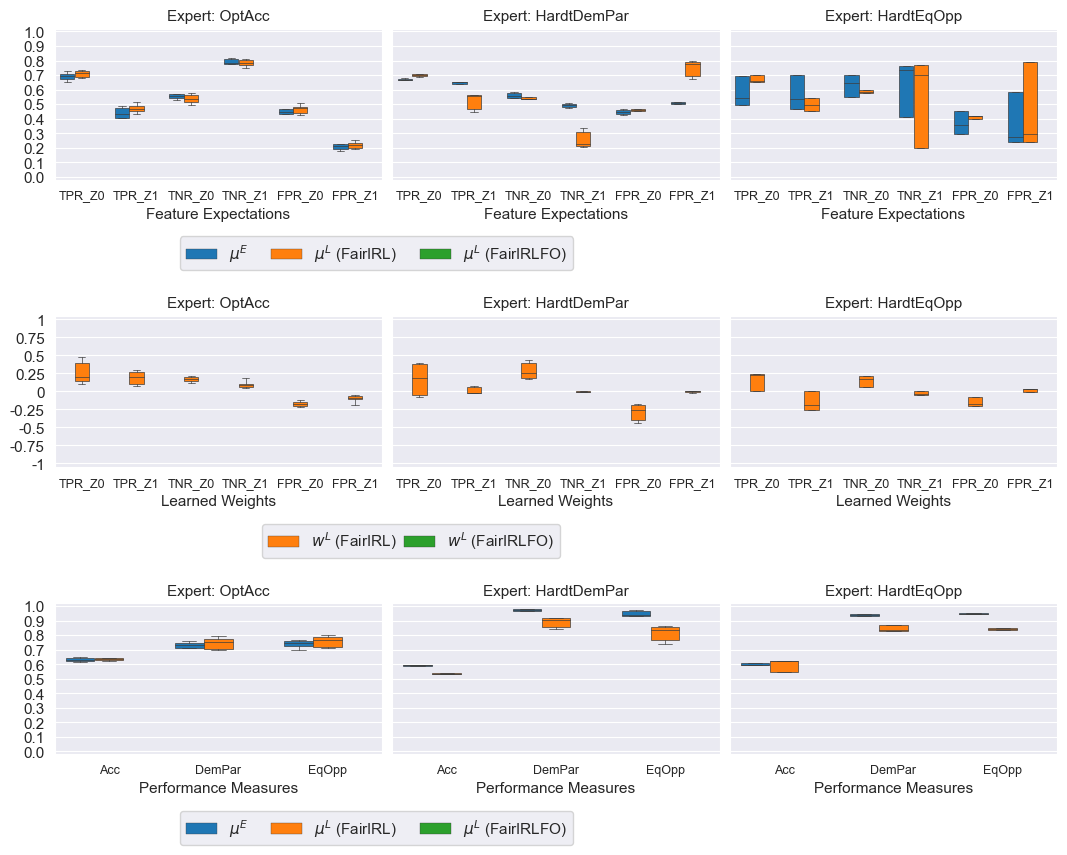

In [260]:
plt.rc('axes', titlesize=11)     # fontsize of the axes title
plt.rc('axes', labelsize=11)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=11)  # fontsize of the figure title

fig, axes, mu_dfs, w_dfs, perf_dfs = plot_results_source_domain_only(
    feat_objective_set_names=base_exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
    perf_objective_set_names=base_exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    expert_algos=[
        'OptAcc',
        'HardtDemPar',
        'HardtEqOpp',
    ],
    dataset=base_exp_info['DATASET'],
    mu_noise_factor=.01,
    perf_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    perf_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
#     min_mu_value=.25,
#     max_mu_value=1,
#     min_w_value=-1,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    perf_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(-.02, 1.02),
    perf_ylim=(-.02, 1.02),
    mu_whis=[1, 99],
    w_yticks = [-1, -.75, -.5, -.25, 0, .25, .5, .75, 1],
    w_ylim=(-1.05, 1.05),
    w_whis=[5, 95]
)

# Compare results with target domain

KeyError: 'OBJECTIVE_NAMES'

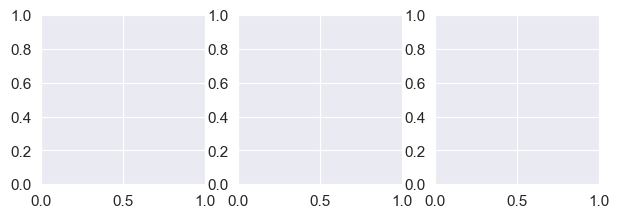

In [746]:
## plt.rc('axes', titlesize=11)     # fontsize of the axes title
plt.rc('axes', labelsize=11)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=10.5)    # legend fontsize
plt.rc('figure', titlesize=11)  # fontsize of the figure title

mu_df, w_df = plot_results_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algos=['OptAcc', 'HardtDemPar', 'HardtEqOpp'],
    source_dataset=base_exp_info['DATASET'],
    target_dataset=base_exp_info['TARGET_DATASET'],
    mu_noise_factor=.05,
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    min_mu_value=.5,
#     mu_yticks=[.6, .7, .8, .9, 1],
    mu_yticks=[.4, .5, .6, .7, .8, .9, 1],
    mu_ylim=(.45, 1.02),
    mu_whis=[5, 95],
)

# Scratch

In [9]:
exp_info = dict(base_exp_info)
exp_info['FEAT_EXP_OBJECTIVE_NAMES'] = [
    'TPR_Z0', 'TPR_Z1',
    'TNR_Z0', 'TNR_Z1',
#     'FPR_Z0', 'FPR_Z1',
#     'FNR_Z0', 'FNR_Z1',
#     'Acc',
#     'DemPar',
#     'EqOpp',
#     'PredPar',
]
exp_info['RESTRICT_Y_ACTION'] = True

X, y, ft = generate_compas_dataset(20_000)
# X, y, ft = generate_adult_dataset(20_000)

# Initiate objectives
objectives = []
for obj_name in exp_info['FEAT_EXP_OBJECTIVE_NAMES']:
    objectives.append(OBJ_LOOKUP_BY_NAME[obj_name]())
feat_obj_set = ObjectiveSet(objectives)
del objectives
# Reset the objective set since they get fitted in each trial run
feat_obj_set.reset()


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.2,
)
del X, y


# Fit a classifier that predicts `y` from `X`.
clf = sklearn_clf_pipeline(
    feature_types=ft,
    clf_inst=RandomForestClassifier(),
)
clf.fit(X_train, y_train)

# Initiate variables needed to run IRL Loop
x_cols = (
    ft['boolean']
    + ft['categoric']
    + ft['continuous']
)
x_cols.remove('z')

wi = [.75, .1, .25, .1]
reward_weights = { obj.name: wi[j] for j, obj in enumerate(feat_obj_set.objectives) }

# test_df = X_test.copy()
# test_df['y'] = y_test
test_df = X_train.copy()
test_df['y'] = y_train
# test_df['y'] = clf.predict(X_test)

clf_pol = compute_optimal_policy(
    clf_df=test_df,  # NOT the dataset used to train the C_{Y_Z,X} clf
    clf=clf,
    x_cols=x_cols,
    obj_set=feat_obj_set,
    reward_weights=reward_weights,
    skip_error_terms=True,
    method=exp_info['METHOD'],
    min_freq_fill_pct=exp_info['MIN_FREQ_FILL_PCT'],
)

demo = generate_demo(clf_pol, X_train, y_train, can_observe_y=False)
muj = feat_obj_set.compute_demo_feature_exp(demo)
print(f"\t\t muL = {np.round(muj, 3)}")


print('Acc', AccuracyObjective().compute_feat_exp(demo).round(3))
print('DemPar', DemographicParityObjective().compute_feat_exp(demo).round(3))
print('EqOpp', EqualOpportunityObjective().compute_feat_exp(demo).round(3))

display(demo.groupby(['z', 'y'])[['yhat']].agg(['count', 'mean', 'sum']))
display(demo.groupby(['z'])[['yhat']].agg(['count', 'mean', 'sum']))

all_splits[0].c -1.0
all_splits[split_i+1].c -1.0000000000000002
all_splits[split_i+1].c -0.9999999999999999
all_splits[split_i+1].c -0.9999999999999999
best_reward 0.11187335173918216
		 muL = [0.533 0.357 0.685 0.811]
Acc 0.61
DemPar 0.835
EqOpp 0.824


yhat                  
    count      mean     sum
z y                        
0 0  4627  0.315323  1459.0
  1  4797  0.532625  2555.0
1 0  2602  0.188701   491.0
  1  1970  0.356853   703.0

yhat                  
  count      mean     sum
z                        
0  9424  0.425934  4014.0
1  4572  0.261155  1194.0

In [4]:
clf_pol.mdp.ldf_

NameError: name 'clf_pol' is not defined

In [577]:
clf_pol.mdp.ldf_['c'] = clf_pol.mdp.opt_problems_[0].c
clf_pol.mdp.ldf_

,gender,v_score_text,z,y,mu0,yhat,c
0,-555,-555,0,0,0.002859,0,-0.376291
1,-555,-555,0,0,0.002859,1,-0.000000
2,-555,-555,0,1,0.004574,0,-0.000000
3,-555,-555,0,1,0.004574,1,-0.740474
4,-555,-555,1,0,0.001715,0,-0.000000
5,-555,-555,1,0,0.001715,1,-0.000000
6,-555,-555,1,1,0.002001,0,-0.000000
7,-555,-555,1,1,0.002001,1,-0.000000
8,-555,Low,0,0,0.054603,0,-0.376291
9,-555,Low,0,0,0.054603,1,-0.000000


In [569]:
clf_pol.mdp.ldf_.query('yhat == 1')

,gender,age_cat,score_text,v_score_text,z,y,mu0,yhat,c
1,Female,25 - 45,High,High,0,0,0.002289,1,-0.000000
3,Female,25 - 45,High,High,0,1,0.000858,1,-0.715016
5,Female,25 - 45,High,High,1,0,0.000286,1,-0.000000
7,Female,25 - 45,High,High,1,1,0.000858,1,-0.897074
9,Female,25 - 45,High,Low,0,0,0.001144,1,-0.000000
...,...,...,...,...,...,...,...,...,...
305,Male,Less than 25,Medium,Low,1,1,0.001144,1,-0.897074
307,Male,Less than 25,Medium,Medium,0,0,0.012589,1,-0.000000
309,Male,Less than 25,Medium,Medium,0,1,0.021459,1,-0.715016
311,Male,Less than 25,Medium,Medium,1,0,0.004006,1,-0.000000


In [548]:
demo

,id,name,first,last,compas_screening_date,gender,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,is_race_white,z,juv_fel_count__0.1,juv_fel_count__0.75,juv_fel_count__0.9,priors_count__0.1,priors_count__0.75,priors_count__0.9,yhat,y
15322,NaN,nathan christie,nathan,christie,23/03/2013,Male,15/12/1984,31,25 - 45,African-American,1,8,1,1,12,-1.0,22/03/2013 10:04,01/05/2013 10:54,13005648MM10A,22/03/2013,NaN,1.0,(M1),Resist/Obstruct W/O Violence,1,16011963TC40A,(M2),NaN,27/02/2016,Operating W/O Valid License,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,23/03/2013,Risk of Violence,5,Medium,23/03/2013,14/05/2013,04/06/2013,12,39,52,0,0,0,False,False,False,False,False,False,1.0,1
13978,NaN,eric saddler,eric,saddler,17/05/2013,Male,21/08/1984,31,25 - 45,African-American,0,1,0,0,2,-1.0,16/05/2013 11:28,18/05/2013 4:21,13007041CF10A,16/05/2013,NaN,1.0,(F3),Grand Theft in the 3rd Degree,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,17/05/2013,Risk of Violence,2,Low,17/05/2013,16/05/2013,18/05/2013,2,1,1050,0,0,0,True,True,True,False,True,True,0.0,0
2524,2525.0,eric evenson,eric,evenson,01/10/2013,Male,09/07/1991,24,Less than 25,Caucasian,0,6,0,0,2,-27.0,04/09/2013 6:36,04/09/2013 6:53,13012482CF10A,04/09/2013,NaN,27.0,(F3),Possession Of Alprazolam,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,01/10/2013,Risk of Violence,5,Medium,01/10/2013,31/10/2013,13/11/2013,2,0,30,0,1,1,True,True,True,False,True,True,1.0,0
5193,5194.0,cassye swisher,cassye,swisher,21/10/2014,Female,25/07/1988,27,25 - 45,Caucasian,0,5,0,0,4,-262.0,01/02/2014 3:35,02/02/2014 3:40,14001450CF10A,01/02/2014,NaN,262.0,(F3),Possession of Cocaine,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,21/10/2014,Risk of Violence,2,Low,21/10/2014,01/02/2014,02/02/2014,4,0,528,0,1,1,True,True,True,False,True,True,1.0,0
3565,3566.0,nikeisha porter,nikeisha,porter,26/11/2013,Female,16/01/1974,42,25 - 45,African-American,0,2,0,0,2,-1.0,25/11/2013 5:04,26/11/2013 9:36,13016423CF10A,25/11/2013,NaN,1.0,(F1),Burglary With Assault/battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,2,Low,26/11/2013,Risk of Violence,1,Low,26/11/2013,25/11/2013,26/11/2013,2,0,857,0,0,0,True,True,True,False,True,True,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14248,NaN,keandre owens,keandre,owens,18/01/2013,Male,27/10/1993,22,Less than 25,African-American,0,7,0,0,0,-1.0,17/01/2013 1:22,08/03/2013 4:39,13000825CF10A,17/01/2013,NaN,1.0,(F2),Burglary Unoccupied Dwelling,1,13022001MM10A,(M1),0.0,22/11/2013,Petit Theft $100- $300,22/11/2013,11/12/2013,NaN,1,14009268CF10A,(F2),21/06/2014,Robbery / No Weapon,Risk of Recidivism,7,Medium,18/01/2013,Risk of Violence,7,Medium,18/01/2013,22/11/2013,11/12/2013,0,327,519,1,0,0,True,True,True,True,True,True,1.0,1
10533,10534.0,dernard adderley,dernard,adderley,04/01/2013,Male,29/05/1988,27,25 - 45,African-American,0,5,0,0,2,-1.0,03/01/2013 8:36,18/01/2013 9:00,13000178MM10A,03/01/2013,NaN,1.0,(M2),Prowling/Loitering,1,13001871MM10A,(M2),0.0,26/01/2013,Prowling/Loitering,26/01/2013,21/02/2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,04/01/2013,Risk of Violence,3,Low,04/01/

In [532]:
.5*.712 + .2*.437 + .5*.55 + .2*.814

0.8812